In [1]:
#get larlite
from larlite import larlite as ll
from larlite import larutil as lu

geo=lu.Geometry.GetME()
geoH=lu.GeometryHelper.GetME()

import ROOT

In [2]:
#graphics 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#create storage manager
sm = ll.storage_manager()
sm.set_io_mode(ll.storage_manager.kREAD)
FILENAME="../../../App/mac/test_output.root"
sm.add_in_filename(FILENAME)
sm.open()

True

In [4]:
#there is only 1 event
sm.next_event()

True

In [5]:
#get hits and clusters
event_hits     = sm.get_data(ll.data.kHit,"gaushit")
event_clusters = sm.get_data(ll.data.kCluster,"ImageClusterHit")

#get ass
event_ass      = sm.get_data(ll.data.kAssociation,"ImageClusterHit")

#get association
cluster_to_hit_ass = event_ass.association(event_clusters.id(),event_hits.id())

#get the vertex_data
event_vertex = sm.get_data(ll.data.kVertex,"numuCC_vertex")

#get contour data
event_user = sm.get_data(ll.data.kUserInfo,"ImageClusterHit")

In [6]:
import root_numpy as rn
gausdata = rn.root2array(FILENAME,
                        treename='hit_gaushit_tree',
                        branches=['hit_gaushit_branch.vector<larlite::hit>.fPeakTime',
                                  'hit_gaushit_branch.vector<larlite::hit>.fWireID.Wire',
                                  'hit_gaushit_branch.vector<larlite::hit>.fWireID.Plane'])

import pandas as pd
evt=0
hits_df= pd.DataFrame({'Wire'      : gausdata[evt][1],
                       'PeakTime'  : gausdata[evt][0],
                       'Plane'     : gausdata[evt][2]})

In [7]:
print "There are...",cluster_to_hit_ass.size()," clusters."

There are... 19  clusters.


In [8]:
print event_user.size()

12


In [9]:
event_user[1].dump_contents()

In [10]:
#User info contains lots of stuff, but lets filter it by ID string
plane0 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_cwo_Plane_0_clusters'][0]
plane1 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_cwo_Plane_1_clusters'][0]
plane2 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_cwo_Plane_2_clusters'][0]

In [11]:
#User info contains lots of stuff, but lets filter it by ID string
houghplane0 = event_user[0]
houghplane1 = event_user[4]
houghplane2 = event_user[6]

In [12]:
#convex hull per cluster
hullplane0 = event_user[1]
hullplane1 = event_user[5]
hullplane2 = event_user[9]

In [13]:
#User info contains lots of stuff, but lets filter it by ID string
roiplane0 = event_user[3]
roiplane1 = event_user[7]
roiplane2 = event_user[11]

0


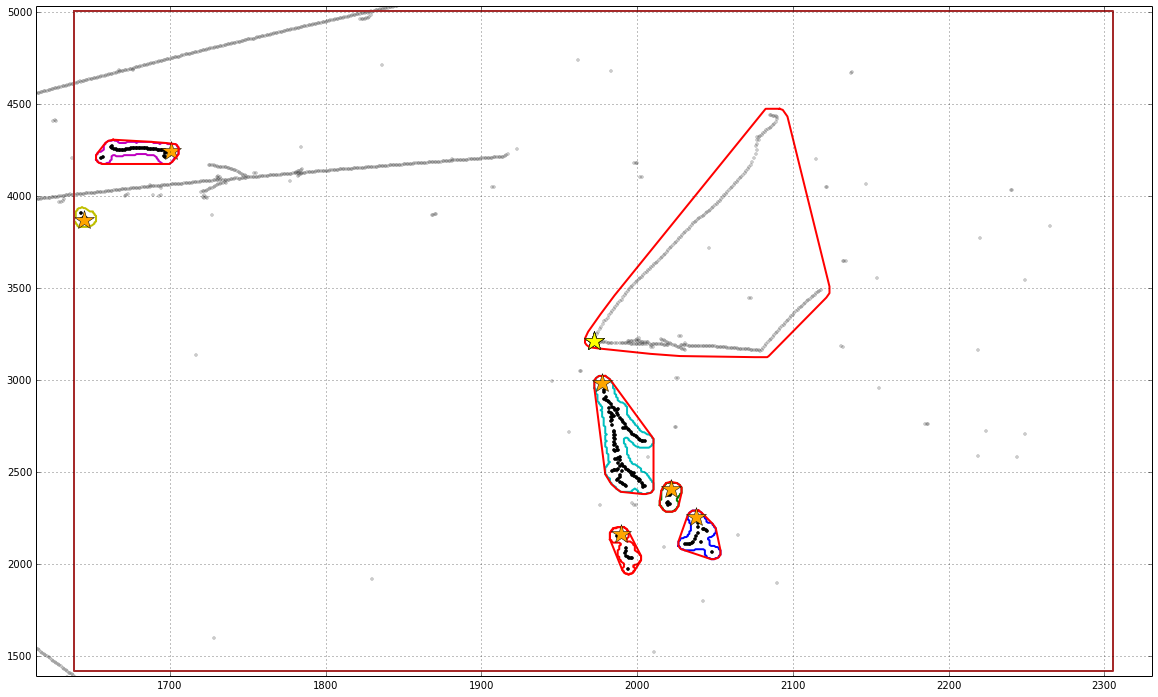

In [14]:
#Show the ImageClusters
plane=2
sbc_data=event_user[plane]
hsv = plt.get_cmap('jet')
lors = hsv(np.linspace(0, 1.0, cluster_to_hit_ass.size()))

fig,ax=plt.subplots(figsize=(10*2,6*2))

phits = hits_df.query("Plane=={}".format(plane))

ax.plot(phits.Wire,phits.PeakTime,'o',color='black',markersize=3,alpha=0.2)

# plot each cluster and userinfo
for ix,cluster in enumerate(cluster_to_hit_ass):
    
    ##############################
    #get the hits for this clusters
    slice_=np.array(cluster)
    if event_clusters[ix].Plane().Plane != plane: continue
    if slice_.size == 0: continue

    hslice = hits_df.iloc[slice_]
    ax.plot(hslice.Wire,hslice.PeakTime,'o',color='black',markersize=3)

    ##############################
    #call user_info get_darray, for the contour   
    
    exec("cluster_data = plane%s"%plane)

    
    cid = event_clusters[ix].ID()
    xx=np.array(cluster_data.get_darray('ClusterID_{}_contour_x'.format(cid)))
    yy=np.array(cluster_data.get_darray('ClusterID_{}_contour_y'.format(cid)))

    xx=np.append(xx,xx[0])
    yy=np.append(yy,yy[0])

    plt.plot(yy,xx,'-',lw=2)

    
    ##############################
    #put the hull info on
    exec("hull_data = hullplane%s"%plane)
    xx=np.array(hull_data.get_darray('ClusterID_{}_hull_x'.format(cid)))
    yy=np.array(hull_data.get_darray('ClusterID_{}_hull_y'.format(cid)))

    xx=np.append(xx,xx[0])
    yy=np.append(yy,yy[0])

    plt.plot(yy,xx,'-',lw=2,color='red')
    
    ##############################
    #put vertex information on screen as a big star 
    
    vtx=ROOT.std.vector('double')()
    vtx.resize(3)
    vtx[0]=event_vertex[0].X()
    vtx[1]=event_vertex[0].Y()
    vtx[2]=event_vertex[0].Z()
    px = geoH.Point_3Dto2D(vtx.data(),plane)
    pt=np.array([px.w/geoH.WireToCm(),px.t//geoH.TimeToCm()+800.0])
    
    ax.plot(pt[0],pt[1],'*',markersize=20,color='yellow')
    
    ##############################
    #can we overlay the start points?
    
    startx = cluster_data.get_double("ClusterID_{}_startPt_x".format(cid))
    starty = cluster_data.get_double("ClusterID_{}_startPt_y".format(cid))
    ax.plot(starty,startx,'*',markersize=20,color='orange')


exec("roi_data = roiplane%s"%plane)  
##############################
#put the bounding box in
    
bbx=np.array(roi_data.get_darray('roi_bounds_x'))
bby=np.array(roi_data.get_darray('roi_bounds_y'))

bbx=np.append(bbx,bbx[0])
bby=np.append(bby,bby[0])
plt.plot(bbx,bby,'-',lw=2,color='brown')

ax.set_xlim(bbx.min()-25,bbx.max()+25)
ax.set_ylim(bby.min()-25,bby.max()+25)

##############################
#can we overlay the hough lines?
exec("houghdata = houghplane%s"%plane)
nlines=houghdata.get_int('N_lines')
print nlines
for n in xrange(nlines):
    x1=houghdata.get_double("line_{}_x1".format(n))
    y1=houghdata.get_double("line_{}_y1".format(n))
    x2=houghdata.get_double("line_{}_x2".format(n))
    y2=houghdata.get_double("line_{}_y2".format(n))
    ax.plot([y1,y2],[x1,x2],'--',lw=3,color='yellow')

    

plt.grid()
plt.show()

In [15]:
plane2.dump_contents()

In [16]:
houghplane0.dump_contents()